In [28]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

import fiona
import folium
from shapely import wkt
from shapely.geometry import shape
from shapely.geometry import Polygon, MultiPolygon, GeometryCollection
from shapely.ops import unary_union
import ast

from loguru import logger
from pathlib import Path
from tqdm import tqdm
from geowrangler.datasets import geofabrik
from geowrangler import distance_zonal_stats as dzs
from geowrangler import vector_zonal_stats as vzs
from geowrangler.validation import GeometryValidation

In [21]:
# custom module
import sys

sys.path.append("../../")  # include parent directory
from src.vector_utils import one_sided_poly_buffer

# Generate coastal buffer

### Set input parameters

In [31]:
DATA_DIR = Path("../../data/")
OUTPUT_FPATH = DATA_DIR / "04-output"

# admin bounds
ADMIN_BOUNDS_PROJECT_ID = "tm-geodata-warehouse"
ADMIN_BOUNDS_BQ_TABLE = "ph_admin_boundary_dec2017.level1_region"

PROJ_CRS = "epsg:3123"
# Buffer settings
BUFFER_M = 3_000
SIMPLIFY = True

### Load Admin Boundaries

In [3]:
%%time
query = f"""
    SELECT
        ADM1_EN,
        geometry
    FROM
      `{ADMIN_BOUNDS_BQ_TABLE}`
"""
bounds = pd.read_gbq(query, ADMIN_BOUNDS_PROJECT_ID, progress_bar_type="tqdm")
bounds.head()

Downloading: 100%|██████████|
CPU times: user 8.54 s, sys: 1.51 s, total: 10 s
Wall time: 9min 20s


,ADM1_EN,geometry
0,Region IV-A,MULTIPOLYGON (((122.7216452990001 13.364847839...
1,Region I,MULTIPOLYGON (((119.8659631480001 15.815394096...
2,National Capital Region,"POLYGON ((121.038416598 14.78524708100002, 121..."
3,Cordillera Administrative Region,"POLYGON ((121.2220811540001 18.50058094200006,..."
4,Region III,MULTIPOLYGON (((120.1168680120001 14.763089660...


In [4]:
%%time
bounds["geometry"] = gpd.GeoSeries.from_wkt(bounds["geometry"])
bounds = gpd.GeoDataFrame(bounds, geometry="geometry", crs="epsg:4326")
bounds = bounds.to_crs(crs=PROJ_CRS)

CPU times: user 11.4 s, sys: 117 ms, total: 11.5 s
Wall time: 11.4 s


In [5]:
bounds.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   ADM1_EN   17 non-null     object  
 1   geometry  17 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 400.0+ bytes


In [6]:
%%time
bounds = bounds.unary_union
type(bounds)

CPU times: user 44.5 s, sys: 859 ms, total: 45.4 s
Wall time: 45.5 s


shapely.geometry.multipolygon.MultiPolygon

In [7]:
%%time
# need to simplify geometry since it's too high res
if SIMPLIFY:
    bounds = bounds.simplify(tolerance=10)

CPU times: user 18.2 s, sys: 725 ms, total: 18.9 s
Wall time: 18.9 s


In [8]:
len(bounds.geoms)

3655

In [24]:
%%time
print(f"Generating {BUFFER_M}m buffer")

buffered_bounds = []

for poly in tqdm(bounds.geoms):
    buffered_bound = one_sided_poly_buffer(poly, BUFFER_M)

    # making sure each element in the final list is a polygon, no multipolygons
    if isinstance(buffered_bound, Polygon):
        buffered_bounds.append(buffered_bound)
    elif isinstance(buffered_bound, MultiPolygon):
        buffered_bounds.extend(list(buffered_bound.geoms))
    elif isinstance(buffered_bound, GeometryCollection):
        # if it's a geometry collection, it means the buffer resulted in a very irregular geometry
        # so just keep the original polygon
        buffered_bounds.append(poly)
    else:
        raise ValueError(f"Invalid type {type(buffered_bound)}, please recheck data")

buffered_bounds = MultiPolygon(buffered_bounds)

Generating 3000m buffer


100%|██████████| 3655/3655 [02:12<00:00, 27.48it/s] 

CPU times: user 2min 13s, sys: 0 ns, total: 2min 13s
Wall time: 2min 13s


In [25]:
%%time

# Convert to GeoSeries and explode polygons
buffered_bounds = gpd.GeoSeries(buffered_bounds, crs=PROJ_CRS)
buffered_bounds = buffered_bounds.explode(ignore_index=True)
buffered_bounds = buffered_bounds.to_crs(crs="epsg:4326")
buffered_bounds.head()

CPU times: user 391 ms, sys: 0 ns, total: 391 ms
Wall time: 395 ms


0    POLYGON ((119.20750 4.66894, 119.20565 4.66970...
1    POLYGON ((119.03140 4.70875, 119.03071 4.70988...
2    POLYGON ((119.14743 4.72209, 119.14804 4.72133...
3    POLYGON ((119.23685 4.72612, 119.23621 4.72625...
4    POLYGON ((118.31838 6.08666, 118.31951 6.08667...
dtype: geometry

In [26]:
# Convert to GeoDataFrame
buffered_bounds = gpd.GeoDataFrame(buffered_bounds).reset_index()
buffered_bounds = buffered_bounds.rename(columns={0: "geometry", "index": "uid"})
buffered_bounds.head()

,uid,geometry
0,0,"POLYGON ((119.20750 4.66894, 119.20565 4.66970..."
1,1,"POLYGON ((119.03140 4.70875, 119.03071 4.70988..."
2,2,"POLYGON ((119.14743 4.72209, 119.14804 4.72133..."
3,3,"POLYGON ((119.23685 4.72612, 119.23621 4.72625..."
4,4,"POLYGON ((118.31838 6.08666, 118.31951 6.08667..."


In [29]:
%%time
# Fixing Invalid Geometries
# defined validators here since crs_bounds validator doesn't work
validators = ("null", "self_intersecting", "orientation", "area")
buffered_bounds = GeometryValidation(
    buffered_bounds, validators=validators, add_validation_columns=False
).validate_all()
buffered_bounds.head()

CPU times: user 2.03 s, sys: 50.1 ms, total: 2.08 s
Wall time: 2.08 s


,uid,geometry
0,0,"POLYGON ((119.20750 4.66894, 119.20800 4.66899..."
1,1,"POLYGON ((119.03140 4.70875, 119.03178 4.70845..."
2,2,"POLYGON ((119.14743 4.72209, 119.14709 4.72227..."
3,3,"POLYGON ((119.23685 4.72612, 119.23756 4.72612..."
4,4,"POLYGON ((118.31838 6.08666, 118.31679 6.08666..."


/home/abbymoreno/miniconda3/envs/lacuna-fund2/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


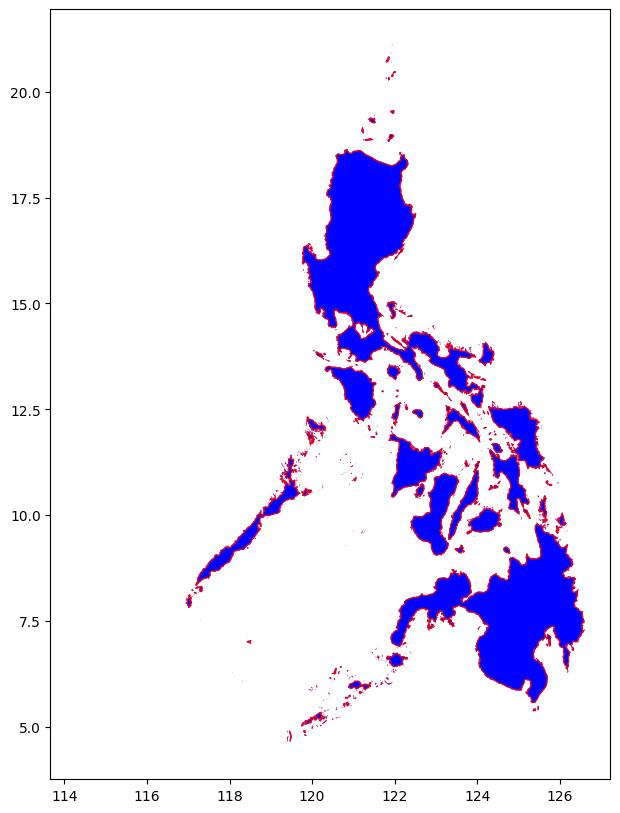

CPU times: user 1.89 s, sys: 523 ms, total: 2.42 s
Wall time: 1.74 s


In [30]:
%%time
orig = gpd.GeoSeries(MultiPolygon([Polygon(b) for b in bounds.geoms]), crs=PROJ_CRS)
orig = orig.to_crs("epsg:4326")

fig, ax = plt.subplots(figsize=(10, 10))
orig.plot(ax=ax, color="blue", label="orig")
buffered_bounds.plot(ax=ax, color="red", label="one-sided buffer")
plt.show()

In [32]:
buffered_bounds.to_file(OUTPUT_FPATH / "ph_coasts_3000m.gpkg", driver="GPKG")

/home/abbymoreno/miniconda3/envs/lacuna-fund2/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### Keep for visualization

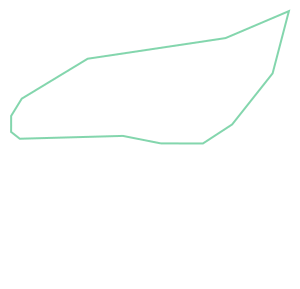

In [9]:
bounds.geoms[3].boundary

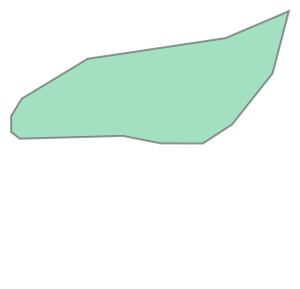

In [10]:
bounds.geoms[3]

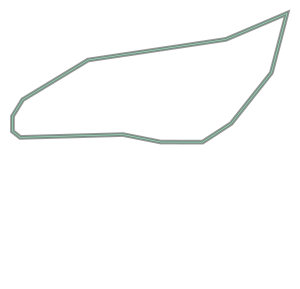

In [11]:
# simple buffer example
buffer_m = 5
single_sided_buffer = bounds.geoms[3].boundary.buffer(-buffer_m, single_sided=True)
single_sided_buffer

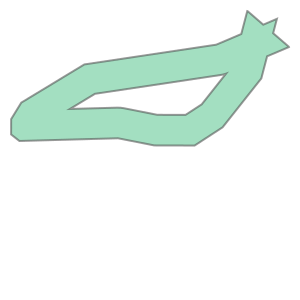

In [12]:
# simple buffer example
buffer_m = 60
single_sided_buffer = bounds.geoms[3].boundary.buffer(-buffer_m, single_sided=True)
single_sided_buffer

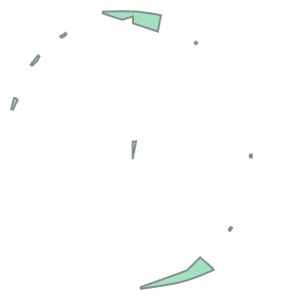

In [16]:
poly = bounds.geoms[3]
buffer_m = 3_000
bound = poly.boundary
buffered_bound = bound.buffer(-buffer_m / 2, single_sided=True)

buffered_bound

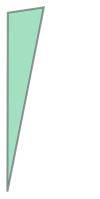

In [17]:
# take the intersection to remove the outward spikes from a single sided buffer
buffered_bound = buffered_bound.intersection(poly)

buffered_bound

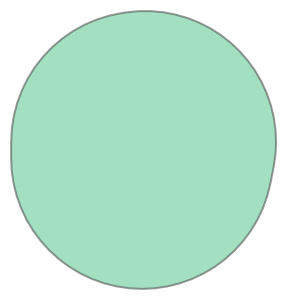

In [18]:
# buffer it again to fill in inward spikes
buffered_bound = buffered_bound.buffer(buffer_m / 2)

buffered_bound

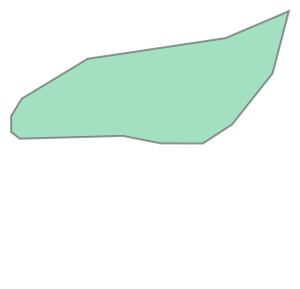

In [19]:
# take intersection to remove outward spikes again
buffered_bound = buffered_bound.intersection(poly)

buffered_bound